In [1]:
from math import ceil
from collections import Counter

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# define quantization tables
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

In [3]:
# define window size
windowSize = len(QTY) # 8 by default

In [4]:
# read image
imgOriginal = cv2.imread('marbles.bmp', cv2.IMREAD_COLOR)
imgRGB = cv2.imread('marbles.bmp', cv2.COLOR_BGR2RGB)
# convert BGR to YCrCb
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCR_CB)

(-0.5, 1418.5, 1000.5, -0.5)

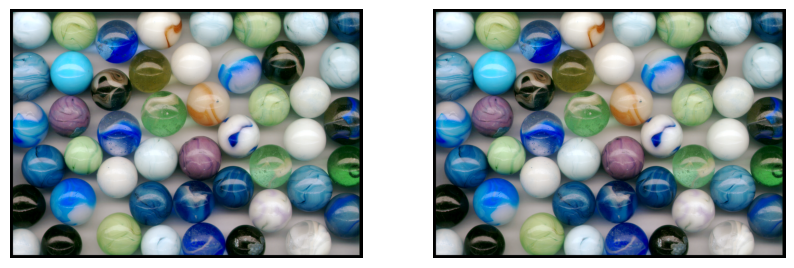

In [66]:
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(imgOriginal)
ax[0].axis('off')
ax[1].imshow(imgRGB)
ax[1].axis('off')

In [6]:
# img is like this (rows, columns, rgb pixel data)
img.shape

(1001, 1419, 3)

In [7]:
width = len(img[0])
height = len(img)

# splitting y, cb, cr channels
y = np.zeros((height, width), np.float32) + img[:, :, 0]
cr = np.zeros((height, width), np.float32) + img[:, :, 1]
cb = np.zeros((height, width), np.float32) + img[:, :, 2]

In [8]:
y.shape, cr.shape, cb.shape

((1001, 1419), (1001, 1419), (1001, 1419))

In [9]:
y[200:201, :], cr[200:201, :], cb[200:201, :]

(array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[128., 128., 128., ..., 128., 128., 128.]], dtype=float32),
 array([[128., 128., 128., ..., 128., 128., 128.]], dtype=float32))

In [10]:
# Finding unique pixels in the image
# Reshape the image to a 2D array of shape (1001*1419, 3)
reshaped_img = img.reshape(-1, 3)
unique_colors = np.unique(reshaped_img, axis=0)

print("Shape of the reshaped image:", reshaped_img.shape)
print("Shape of the unique_colors matrix:", unique_colors.shape)

Shape of the reshaped image: (1420419, 3)
Shape of the unique_colors matrix: (89501, 3)


In [11]:
print("Percent of pixels that are unique:", (unique_colors.shape[0] / reshaped_img.shape[0]) * 100)

Percent of pixels that are unique: 6.301028076926597


In [12]:
def bits_to_something(bits, something="kb"):
    bytes = bits / 8
    kb = bytes / 1024
    mb = kb / 1024
    if (something == "bytes"):
        return np.round(bytes, 2)
    elif (something == "kb"):
        return np.round(kb, 2)
    else:
        return np.round(mb, 2)

In [13]:
# size of the image in bits before compression
totalNumberOfBitsWithoutCompression = len(y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8
totalNumberOfBitsWithoutCompression

34090056

In [14]:
print("Size of the image before compression:", bits_to_something(totalNumberOfBitsWithoutCompression, "mb"), "MB")

Size of the image before compression: 4.06 MB


In [15]:
# channel values should be normalized, hence subtract 128
y = y - 128
cr = cr - 128
cb = cb - 128

In [16]:
# 4: 2: 0 subsampling is used
# another subsampling scheme can be used
# thus chrominance channels should be sub-sampled
# define subsampling factors in both horizontal and vertical directions
SSH, SSV = 2, 2
# filter the chrominance channels using a 2x2 averaging filter # another type of filter can be used
crf = cv2.boxFilter(cr, ddepth=-1, ksize=(2, 2))
cbf = cv2.boxFilter(cb, ddepth=-1, ksize=(2, 2))
crSub = crf[::SSV, ::SSH]
cbSub = cbf[::SSV, ::SSH]

In [17]:
cb[14:18, 10:16]

array([[  0.,   0., -34., -32., -29., -24.],
       [  0.,   0., -30., -29., -24., -20.],
       [  0.,   0., -25., -25., -21., -19.],
       [  0.,   0., -27., -24., -21., -15.]], dtype=float32)

In [18]:
cbf[14:18, 10:16]

array([[  0.  ,   0.  , -15.75, -31.75, -31.25, -27.  ],
       [  0.  ,   0.  , -16.  , -31.25, -28.5 , -24.25],
       [  0.  ,   0.  , -13.75, -27.25, -24.75, -21.  ],
       [  0.  ,   0.  , -13.  , -25.25, -22.75, -19.  ]], dtype=float32)

In [19]:
# measuring the compression achieved after using chroma subsampling
y_dim = y.shape
cb_dim = cbSub.shape
cr_dim = crSub.shape
totalBits = y_dim[0] * y_dim[1] * 8 + cb_dim[0] * cb_dim[1] * 8 + cr_dim[0] * cr_dim[1] * 8
print(
    "Compression Ratio after chroma subsampling is " + str(
        np.round(totalNumberOfBitsWithoutCompression / totalBits, 1)))

Compression Ratio after chroma subsampling is 2.0


In [20]:
print("Size of the image after chroma subsampling:", bits_to_something(totalBits, "mb"), "MB")

Size of the image after chroma subsampling: 2.03 MB


In [21]:
len(y), len(y[0])

(1001, 1419)

In [22]:
# Padding with zeros may be required because DCT and quantization are applied only on 8 * 8 matrices.

# check if padding is needed,
# if yes define empty arrays to pad each channel DCT with zeros if necessary
yWidth, yLength = ceil(len(y[0]) / windowSize) * windowSize, ceil(len(y) / windowSize) * windowSize
if (len(y[0]) % windowSize == 0) and (len(y) % windowSize == 0):
    yPadded = y.copy()
else:
    yPadded = np.zeros((yLength, yWidth))
    for i in range(len(y)):
        for j in range(len(y[0])):
            yPadded[i, j] += y[i, j]

# chrominance channels have the same dimensions, meaning both can be padded in one loop
cWidth, cLength = ceil(len(cbSub[0]) / windowSize) * windowSize, ceil(len(cbSub) / windowSize) * windowSize
if (len(cbSub[0]) % windowSize == 0) and (len(cbSub) % windowSize == 0):
    crPadded = crSub.copy()
    cbPadded = cbSub.copy()
# since chrominance channels have the same dimensions, one loop is enough
else:
    crPadded = np.zeros((cLength, cWidth))
    cbPadded = np.zeros((cLength, cWidth))
    for i in range(len(crSub)):
        for j in range(len(crSub[0])):
            crPadded[i, j] += crSub[i, j]
            cbPadded[i, j] += cbSub[i, j]

In [23]:
print("Before padding with zeros: ", y.shape)
print("\nAfter padding with zeros: ", yPadded.shape)

Before padding with zeros:  (1001, 1419)

After padding with zeros:  (1008, 1424)


In [24]:
# get DCT of each channel

# define three empty matrices
yDct, crDct, cbDct = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))

# number of iteration on x axis and y axis to calculate the luminance cosine transform values
hBlocksForY = int(len(yDct[0]) / windowSize)  # number of blocks in the horizontal direction for luminance
vBlocksForY = int(len(yDct) / windowSize)  # number of blocks in the vertical direction for luminance
# number of iteration on x axis and y axis to calculate the chrominance channels cosine transforms values
hBlocksForC = int(len(crDct[0]) / windowSize)  # number of blocks in the horizontal direction for chrominance
vBlocksForC = int(len(crDct) / windowSize)  # number of blocks in the vertical direction for chrominance


In [25]:
# define 3 empty matrices to store the quantized values
yq, crq, cbq = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))
# and another 3 for the zigzags
yZigzag = np.zeros(((vBlocksForY * hBlocksForY), windowSize * windowSize))
crZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))
cbZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))

In [26]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output

In [27]:
# DCT on the luminance channel, i.e. Y

yCounter = 0
for i in range(vBlocksForY):
    for j in range(hBlocksForY):
        yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            yPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        # print("DCT of Y channel: ", yDct)
        # Quantizing the DCT output
        yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTY)
        # print("\nQuantization of the DCT of Y channel: ", yq)
        # doing the zigzag traversal to increase the chances of zeros occuring together
        yZigzag[yCounter] += zigzag(
            yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        # print("\nZigzag traversal of the Y channel: ", yZigzag)
        yCounter += 1
yZigzag = yZigzag.astype(np.int16)

In [28]:
print("DCT Coefficients (Y Channel) matrix shape: \n", yDct.shape)
print("\nQuantized DCT Coefficients (Y Channel) matrix shape: \n", yq.shape)
print("\nZigzag Traversed Quantized Coefficients (Y Channel) matrix shape: \n", yZigzag.shape)

DCT Coefficients (Y Channel) matrix shape: 
 (1008, 1424)

Quantized DCT Coefficients (Y Channel) matrix shape: 
 (1008, 1424)

Zigzag Traversed Quantized Coefficients (Y Channel) matrix shape: 
 (22428, 64)


In [29]:
print("DCT Coefficients (Y Channel): \n", yDct[:3, :50])
print("\nQuantized DCT Coefficients (Y Channel): \n", yq[:3, :50])
print("\nZigzag Traversed Quantized Coefficients (Y Channel): \n", yZigzag[:3, :])

DCT Coefficients (Y Channel): 
 [[-1024.     0.     0.     0.     0.     0.     0.     0. -1024.     0.
      0.     0.     0.     0.     0.     0. -1024.     0.     0.     0.
      0.     0.     0.     0. -1024.     0.     0.     0.     0.     0.
      0.     0. -1024.     0.     0.     0.     0.     0.     0.     0.
  -1024.     0.     0.     0.     0.     0.     0.     0. -1024.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0. 

In [30]:
# DCT on the chroma channels, i.e. Cb and Cr

# either crq or cbq can be used to compute the number of blocks
cCounter = 0
for i in range(vBlocksForC):
    for j in range(hBlocksForC):
        crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            crPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC)
        crZigzag[cCounter] += zigzag(
            crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            cbPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC)
        cbZigzag[cCounter] += zigzag(
            cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cCounter += 1
crZigzag = crZigzag.astype(np.int16)
cbZigzag = cbZigzag.astype(np.int16)

In [31]:
print("DCT Coefficients (Cb Channel) matrix shape: \n", cbDct.shape)
print("\nQuantized DCT Coefficients (Cb Channel) matrix shape: \n", cbq.shape)
print("\nZigzag Traversed Quantized Coefficients (Cb Channel) matrix shape: \n", cbZigzag.shape)

DCT Coefficients (Cb Channel) matrix shape: 
 (504, 712)

Quantized DCT Coefficients (Cb Channel) matrix shape: 
 (504, 712)

Zigzag Traversed Quantized Coefficients (Cb Channel) matrix shape: 
 (5607, 64)


In [32]:
print("DCT Coefficients (Cb Channel): \n", cbDct[:3, :50])
print("\nQuantized DCT Coefficients (Cb Channel): \n", cbq[:3, :50])
print("\nZigzag Traversed Quantized Coefficients (Cb Channel): \n", cbZigzag[:3, :])

DCT Coefficients (Cb Channel): 
 [[-8.56250000e+00  1.12694315e+01 -8.98701565e+00  5.89458177e+00
  -2.81250000e+00  4.80900521e-01  6.78315704e-01 -6.89695286e-01
  -2.10625000e+01 -9.56302562e+00 -2.22874272e+00  8.83701550e-01
   6.25000000e-01 -5.72422478e-01 -9.71010890e-01 -7.25177661e-01
  -1.08750000e+01 -2.55255122e-01 -6.53281482e-01 -4.63816700e-01
   2.50000000e-01  1.37318867e-01 -2.70598050e-01 -3.02468875e-01
  -1.26875000e+01  5.18617001e-01 -3.40651414e-01  1.72500464e-01
   6.87500000e-01  6.63454131e-01 -3.32444152e-01  6.58014903e-01
  -1.32812500e+01 -1.25009553e+00 -3.97191959e-01 -1.49198344e-01
   4.06250000e-01 -9.32427419e-02  2.65996565e-01 -6.29528128e-02
  -1.10937500e+01 -4.34340735e-01  7.46548489e-02 -3.31162938e-02
   3.12500000e-02  1.81360503e-01 -6.47478072e-02 -4.00683803e-03
  -1.04062500e+01  3.83270357e-01]
 [ 1.13090248e+01 -1.48844100e+01  1.18703356e+01 -7.78652848e+00
   3.71628085e+00 -6.36934263e-01 -8.94380600e-01  9.10054062e-01
   2.747

In [33]:
def trim(array: np.ndarray) -> np.ndarray:
    """
    in case the trim_zeros function returns an empty array, add a zero to the array to use as the DC component
    :param numpy.ndarray array: array to be trimmed
    :return numpy.ndarray:
    """
    trimmed = np.trim_zeros(array, 'b')
    if len(trimmed) == 0:
        trimmed = np.zeros(1)
    return trimmed


def run_length_encoding(array: np.ndarray) -> list:
    """
    finds the intermediary stream representing the zigzags
    format for DC components is <size><amplitude>
    format for AC components is <run_length, size> <Amplitude of non-zero>
    :param numpy.ndarray array: zigzag vectors in array
    :returns: run length encoded values as an array of tuples
    """
    encoded = list()
    run_length = 0
    eob = ("EOB",)

    for i in range(len(array)):
        for j in range(len(array[i])):
            trimmed = trim(array[i])
            if j == len(trimmed):
                encoded.append(eob)  # EOB
                break
            if i == 0 and j == 0:  # for the first DC component
                encoded.append((int(trimmed[j]).bit_length(), trimmed[j]))
            elif j == 0:  # to compute the difference between DC components
                diff = int(array[i][j] - array[i - 1][j])
                if diff != 0:
                    encoded.append((diff.bit_length(), diff))
                else:
                    encoded.append((1, diff))
                run_length = 0
            elif trimmed[j] == 0:  # increment run_length by one in case of a zero
                run_length += 1
            else:  # intermediary steam representation of the AC components
                encoded.append((run_length, int(trimmed[j]).bit_length(), trimmed[j]))
                run_length = 0
            # send EOB
        if not (encoded[len(encoded) - 1] == eob):
            encoded.append(eob)
    return encoded

In [34]:
def get_freq_dict(array: list) -> dict:
    """
    returns a dict where the keys are the values of the array, and the values are their frequencies
    :param numpy.ndarray array: intermediary stream as array
    :return: frequency table
    """
    #
    data = Counter(array)
    result = {k: d / len(array) for k, d in data.items()}
    return result

In [35]:
def find_huffman(p: dict) -> dict:
    """
    returns a Huffman code for an ensemble with distribution p
    :param dict p: frequency table
    :returns: huffman code for each symbol
    """
    # Base case of only two symbols, assign 0 or 1 arbitrarily; frequency does not matter
    if len(p) == 2:
        return dict(zip(p.keys(), ['0', '1']))

    # Create a new distribution by merging lowest probable pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    c = find_huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c


def lowest_prob_pair(p):
    # Return pair of symbols from distribution p with lowest probabilities
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    return sorted_p[0][0], sorted_p[1][0]

In [36]:
# find the run length encoding for each channel
yEncoded = run_length_encoding(yZigzag)
print("yEncoded shape: ", len(yEncoded))
print("yEncoded: ", yEncoded[:50])

yEncoded shape:  747505
yEncoded:  [(7, -64), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',), (1, 0), ('EOB',)]


In [37]:
# then get the frequency of each component in order to form a Huffman dictionary
yFrequencyTable = get_freq_dict(yEncoded)
print("yEncoded shape: ", len(yFrequencyTable))
print("yEncoded: ", {key: yFrequencyTable[key] for key in list(yFrequencyTable.keys())[:50]})

yEncoded shape:  444
yEncoded:  {(7, -64): 1.3377836937545568e-06, ('EOB',): 0.0300038126835272, (1, 0): 0.004080240265951399, (6, 40): 0.0001765874475756015, (0, 6, -38): 0.00016989852910682872, (3, 5, -16): 0.0001672229617193196, (0, 3, 4): 0.0031290760596919083, (7, 3, 6): 0.0001672229617193196, (0, 2, 2): 0.013123658035732202, (11, 1, -1): 0.0001672229617193196, (0, 1, -1): 0.012564464451742799, (6, -40): 0.00017524966388184695, (5, 17): 0.00010568491180660999, (0, 5, -21): 2.2742322793827465e-05, (0, 5, -20): 5.484913144393683e-05, (0, 1, 1): 0.4466632330218527, (0, 5, 19): 4.682242928140949e-05, (0, 3, 5): 0.0017163764790870963, (2, 3, 6): 1.0702269550036454e-05, (1, 2, -3): 0.0004267529983077036, (0, 2, -3): 0.002972555367522625, (1, 1, 1): 0.2175329930903472, (0, 2, -2): 0.005525046655206319, (1, 2, 2): 0.0027103497635467323, (2, 1, 1): 0.10570096521093504, (3, 1, 1): 0.05148460545414412, (5, 21): 4.9497996668918603e-05, (0, 3, -4): 0.0017832656637748242, (0, 6, -46): 2.6755673

In [38]:
yHuffman = find_huffman(yFrequencyTable)
print("yEncoded shape: ", len(yHuffman))
print("yEncoded: ", {key: yHuffman[key] for key in list(yHuffman.keys())[:50]})

yEncoded shape:  444
yEncoded:  {(0, 1, 1): '0', (1, 1, 1): '10', (2, 1, 1): '1111', (3, 1, 1): '11101', ('EOB',): '11010', (4, 1, 1): '111001', (0, 1, -1): '110000', (0, 2, 2): '110001', (5, 1, 1): '1110000', (6, 1, 1): '11100011', (0, 2, 3): '11011100', (0, 2, -2): '11011011', (1, 0): '11001101', (0, 3, 4): '111000101', (7, 1, 1): '110111110', (0, 2, -3): '110111111', (1, 1): '110111100', (1, -1): '110111011', (1, 1, -1): '110110100', (1, 2, 2): '110110101', (2, 2): '110011111', (2, -2): '110011101', (0, 3, -4): '110010110', (0, 3, 5): '110010101', (2, -3): '110010000', (2, 3): '110010001', (8, 1, 1): '1110001001', (0, 3, 6): '1101100100', (0, 3, -5): '1101100010', (3, 4): '1101100000', (3, -4): '1101100001', (1, 2, -2): '1100110010', (3, -5): '1100101111', (1, 2, 3): '1100101000', (3, 5): '1100100111', (0, 3, -6): '1100100101', (0, 3, -7): '11100010000', (9, 1, 1): '11011110110', (0, 3, 7): '11011110111', (3, -6): '11011101011', (3, 6): '11011001100', (2, 1, -1): '11011001010', (2, 

In [39]:
crEncoded = run_length_encoding(crZigzag)
crFrequencyTable = get_freq_dict(crEncoded)
crHuffman = find_huffman(crFrequencyTable)

cbEncoded = run_length_encoding(cbZigzag)
cbFrequencyTable = get_freq_dict(cbEncoded)
cbHuffman = find_huffman(cbFrequencyTable)

In [40]:
# calculate the number of bits to transmit for each channel
# and write them to an output file
# file = open("CompressedImage.asfh", "w")
yBitsToTransmit = str()
for value in yEncoded:
    yBitsToTransmit += yHuffman[value]

crBitsToTransmit = str()
for value in crEncoded:
    crBitsToTransmit += crHuffman[value]

cbBitsToTransmit = str()
for value in cbEncoded:
    cbBitsToTransmit += cbHuffman[value]

# if file.writable():
#     file.write(yBitsToTransmit + "\n" + crBitsToTransmit + "\n" + cbBitsToTransmit)
# file.close()

Time it took to run the above cell: 450 seconds or 7.5 minutes.

In [41]:
totalNumberOfBitsAfterCompression = len(yBitsToTransmit) + len(crBitsToTransmit) + len(cbBitsToTransmit)
print(
    "Compression Ratio is " + str(
        np.round(totalNumberOfBitsWithoutCompression / totalNumberOfBitsAfterCompression, 1)))

Compression Ratio is 10.9


In [42]:
totalNumberOfBitsAfterCompression

3121420

In [43]:
print("Size of the image after compression:", bits_to_something(totalNumberOfBitsAfterCompression, "mb"), "MB")

Size of the image after compression: 0.37 MB


In [44]:
yq.shape

(1008, 1424)

In [45]:
cbq.shape

(504, 712)

In [46]:
crq.shape

(504, 712)

In [47]:
y_idct = np.zeros_like(yq)
cb_idct = np.zeros_like(cbq)
cr_idct = np.zeros_like(crq)

y_iq = np.zeros_like(yq)
cb_iq = np.zeros_like(cbq)
cr_iq = np.zeros_like(crq)

In [48]:
yCounter = 0
for i in range(vBlocksForY):
    for j in range(hBlocksForY):
        y_iq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] * QTY)
        y_idct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.idct(
            y_iq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        yCounter += 1
y_unnormalise = y_idct + 128

In [49]:
y_unnormalise

array([[-2.84217094e-14, -2.84217094e-14, -2.84217094e-14, ...,
         1.22850521e+02,  1.31031587e+02,  1.25731226e+02],
       [-2.84217094e-14, -2.84217094e-14, -2.84217094e-14, ...,
         1.22850521e+02,  1.31031587e+02,  1.25731226e+02],
       [-2.84217094e-14, -2.84217094e-14, -2.84217094e-14, ...,
         1.22850521e+02,  1.31031587e+02,  1.25731226e+02],
       ...,
       [ 1.25702516e+02,  1.25702516e+02,  1.25702516e+02, ...,
         1.22022846e+02,  1.23301709e+02,  1.21783306e+02],
       [ 1.28555344e+02,  1.28555344e+02,  1.28555344e+02, ...,
         1.25550623e+02,  1.23235708e+02,  1.29781510e+02],
       [ 1.26917836e+02,  1.26917836e+02,  1.26917836e+02, ...,
         1.26965021e+02,  1.29963793e+02,  1.28992911e+02]])

In [50]:
y + 128

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
cCounter = 0
for i in range(vBlocksForC):
    for j in range(hBlocksForC):
        cr_iq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] * QTC)
        cr_idct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.idct(
            cr_iq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cb_iq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] * QTC)
        cb_idct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.idct(
            cb_iq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cCounter += 1

In [52]:
crSub_upsampled = np.repeat(np.repeat(cr_idct, SSV, axis=0), SSH, axis=1)
cbSub_upsampled = np.repeat(np.repeat(cb_idct, SSV, axis=0), SSH, axis=1)

In [53]:
cb_idct.shape

(504, 712)

In [54]:
cr_unnormalise = crSub_upsampled + 128
cb_unnormalise = cbSub_upsampled + 128

In [55]:
cr_unnormalise

array([[397.64900539, 397.64900539, -16.93171286, ..., 128.        ,
        128.        , 128.        ],
       [397.64900539, 397.64900539, -16.93171286, ..., 128.        ,
        128.        , 128.        ],
       [-16.93171286, -16.93171286, 122.51914915, ..., 128.        ,
        128.        , 128.        ],
       ...,
       [128.        , 128.        , 128.        , ..., 128.        ,
        128.        , 128.        ],
       [128.        , 128.        , 128.        , ..., 128.        ,
        128.        , 128.        ],
       [128.        , 128.        , 128.        , ..., 128.        ,
        128.        , 128.        ]])

In [56]:
cr + 128

array([[128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       ...,
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.]], dtype=float32)

In [57]:
cb_unnormalise

array([[396.44577055, 396.44577055, -15.95446633, ..., 128.        ,
        128.        , 128.        ],
       [396.44577055, 396.44577055, -15.95446633, ..., 128.        ,
        128.        , 128.        ],
       [-15.95446633, -15.95446633, 107.01514534, ..., 128.        ,
        128.        , 128.        ],
       ...,
       [128.        , 128.        , 128.        , ..., 128.        ,
        128.        , 128.        ],
       [128.        , 128.        , 128.        , ..., 128.        ,
        128.        , 128.        ],
       [128.        , 128.        , 128.        , ..., 128.        ,
        128.        , 128.        ]])

In [58]:
cb + 128

array([[128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       ...,
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.],
       [128., 128., 128., ..., 128., 128., 128.]], dtype=float32)

In [59]:
cr_unnormalise.shape

(1008, 1424)

In [60]:
cb_unnormalise.shape

(1008, 1424)

In [61]:
# Combine Y, Cb, and Cr components
ycc_image = np.zeros((y_unnormalise.shape[0], y_unnormalise.shape[1], 3), dtype=np.float32)
ycc_image[:, :, 0] = y_unnormalise
ycc_image[:, :, 1] = cb_unnormalise
ycc_image[:, :, 2] = cr_unnormalise

# Convert YCbCr to RGB
rgb_image = cv2.cvtColor(np.uint8(ycc_image), cv2.COLOR_YCrCb2RGB)

Text(0.5, 1.0, 'Image After Compression')

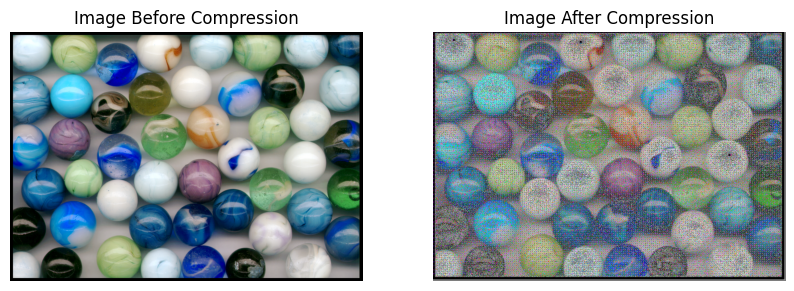

In [69]:
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(imgOriginal)
ax[0].axis('off')
ax[0].set_title('Image Before Compression')
ax[1].imshow(rgb_image)
ax[1].axis('off')
ax[1].set_title('Image After Compression')